In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import mlflow

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
import sys

print(sys.executable)
print(sys.version)

C:\Users\diana\anaconda3\python.exe
3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]


# Weather Forecast with sklearn
### witty subtitle

_D. Tuleva_

_Final Project for Data Science June 2023, SoftUni_

<div style="width: 600px; text-align: justify; padding-left: 100px;"> 
    <h4>Abstract</h4>
    
    The goal of this work is to explore different approaches to weather forecasting and create and evaluate a model for short-term single location weather forecast with sklearn.

</div>

### Helper functions

In [4]:
def plot_temp_histograms(dataframe,  binrange = [-30, 22], binwidth = 2.5):
    
    fig, ax = plt.subplots(2,1, figsize=(12, 8))
    
    sns.histplot(dataframe.temp, binwidth=binwidth, binrange=binrange, ax = ax[0], color = "lime")
    sns.histplot(data = dataframe[["tempmin", "tempmax"]], binwidth=binwidth, binrange=binrange, palette = ["blue", "red"], ax = ax[1])
    
    
    ax[0].set_title("Histogram of Avarage Daily Temperature")
    ax[1].set_title("Histogram of Daily Minimum and Maximum Temperature") 
    
    
    ax[0].set_xlabel("")
    ax[1].set_xlabel("Temperature [$^{\circ}$C]")
    ax[0].set_ylabel("Count [n days]")
    ax[1].set_ylabel("Count [n days]")



def plot_temperatures(dataframe, show = True):
    
    plt.figure(figsize=(13, 6))

    plt.plot(dataframe.datetime, dataframe.tempmax, linewidth=0.4, color = "red", label = "Daily Max Temp")
    plt.plot(dataframe.datetime, dataframe.tempmin, linewidth=0.4, color = "blue", label = "Daily Min Temp")
    plt.plot(dataframe.datetime, dataframe.temp, linewidth=1, color = "lime", label = "Daily Avg Temp")

    if show:
        plt.legend()
        plt.show()


def plot_temp_by_year(dataframe, temp_column = "temp"):
    plt.figure(figsize=(13, 6))

    for year in dataframe.datetime.dt.year.unique():
        plt.plot(mussala_weather_data.datetime.dt.strftime("%m-%d")[mussala_weather_data.datetime.dt.year==year],    mussala_weather_data.temp[mussala_weather_data.datetime.dt.year==year], label = year)
    
    plt.xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
    plt.legend()
    plt.show()

        
def plot_time_series(dataframe, columns):
    if type(columns) == str:
        columns = [columns]
    
    plt.figure(figsize=(12, 6))

    for column_name in columns:
        plt.plot(dataframe.datetime, dataframe[column_name])
   
    plt.show()


def plot_histograms_log_transform(dataframe, column, binwidth = 2, binrange = [0, 60]):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(sofia_weather_data[column], ax = ax1, binwidth = binwidth, binrange = binrange)
    sns.histplot(sofia_weather_data[column][sofia_weather_data[column] > 0], ax = ax2, binwidth = binwidth, binrange = binrange)
    sns.histplot(np.log1p(sofia_weather_data[column][sofia_weather_data[column] > 0]), ax = ax3)
    
    plt.show()



    
    

### Table of contents

1. [Introduction](#introduction)

    1.1. [Related work](#related_work)

2. [Datasets and EDA](#datasets)

   2.1. [Weather Data Mussala](#mussala)
    
   2.2. [Weather Data Sofia](#sofia)

   2.3. [Weather Data Ihtiman](#ihtiman)

   2.4. [Comparing Datasets](#compare_data)

3. [Data Preprocessing](#preprocess)

4. [Models](#models)

5. [Conclusion](#conclusion)

6. [References](#ref)

<a id="introduction"></a>
## 1. Introduction

<a id="datasets"></a>
## 2. Datasets and EDA

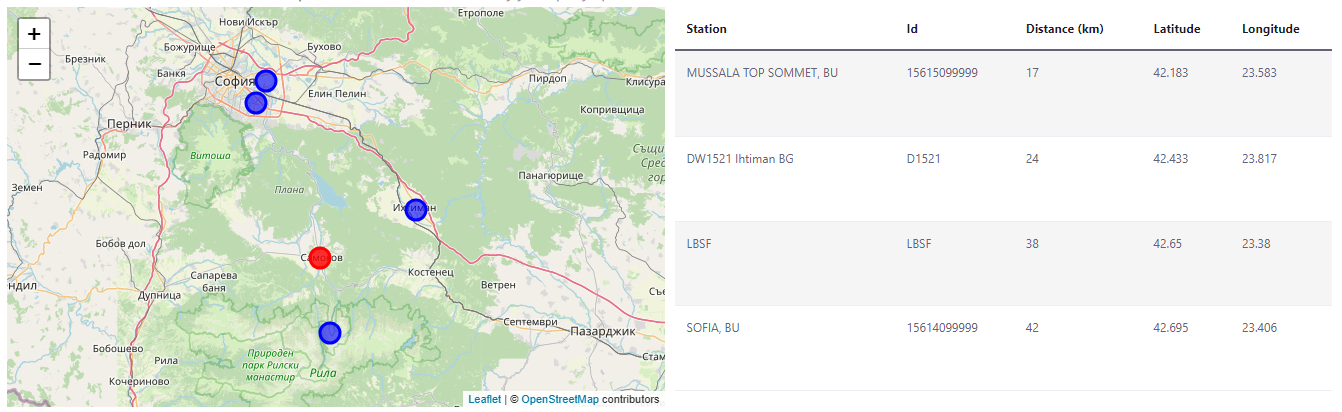

In the following part we explore and visualise our datasets. Some of our feature preprocessing is disscused, but actual preprocessing is done in a pipelines in [this](.WeatherExperiments.ipynb) notebook.

In [5]:
mussala_weather_data = pd.read_csv("data/Samokov 2021-01-01 to 2023-09-01.csv")

In [6]:
mussala_weather_data

,datetime,tempmax,tempmin,temp,dew,humidity,precip,preciptype,windgust,windspeed,winddir,sealevelpressure,cloudcover,conditions,stations
0,2021-01-01,-8.8,-12.1,-11.0,-11.3,98.0,3.0,snow,NaN,50.4,251.2,NaN,11.7,Snow,1.561510e+10
1,2021-01-02,-6.8,-11.6,-8.8,-13.3,73.2,0.0,NaN,86.4,50.4,181.8,NaN,37.5,Partially cloudy,1.561510e+10
2,2021-01-03,-4.6,-8.3,-5.8,-5.9,99.1,3.2,snow,86.4,50.4,179.5,NaN,40.0,"Snow, Partially cloudy",1.561510e+10
3,2021-01-04,-5.1,-6.1,-5.5,-5.5,99.6,18.7,snow,122.4,57.6,156.4,NaN,NaN,Snow,1.561510e+10
4,2021-01-05,-6.9,-11.8,-10.0,-10.8,93.6,5.7,snow,NaN,36.0,273.5,NaN,26.7,"Snow, Partially cloudy",1.561510e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,2023-08-28,14.9,7.6,11.1,4.5,66.0,0.0,NaN,NaN,21.6,345.0,NaN,26.7,Partially cloudy,1.561510e+10
970,2023-08-29,11.2,6.7,9.2,5.8,79.8,0.0,NaN,NaN,28.8,176.3,NaN,42.5,Partially cloudy,1.561510e+10
971,2023-08-30,10.1,5.4,7.0,4.1,82.0,0.0,NaN,NaN,36.0,178.9,NaN,47.5,Partially cloudy,1.561510e+10
972,2023-08-31,7.9,3.4,4.9,3.3,89.9,0.0,NaN,NaN,28.8,239.1,NaN,74.0,Partially cloudy,1.561510e+10


In [7]:
mussala_weather_data.shape

(974, 15)

```Stations``` is supposed to be 10-digit station ID, displaying it with scientific notation makes no sence at all. This dataset is supposed to be for a single location, so we make sure there is only one station id: 

In [8]:
mussala_weather_data.stations.unique()

array([1.56151e+10,         nan])

So the data type is float because of the NaNs. Let's explore the missing values:

In [9]:
mussala_weather_data[mussala_weather_data.stations.isna()]

,datetime,tempmax,tempmin,temp,dew,humidity,precip,preciptype,windgust,windspeed,winddir,sealevelpressure,cloudcover,conditions,stations
42,2021-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
50,2021-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [10]:
mussala_weather_data.isna().sum()

datetime              0
tempmax               2
tempmin               2
temp                  2
dew                   2
humidity              2
precip                2
preciptype          501
windgust            785
windspeed             0
winddir               2
sealevelpressure    974
cloudcover          187
conditions            2
stations              2
dtype: int64

Two days of data are missing - too few to be of high importance, but since we do not want missing values in our time series, we can impute them by simply interpolating between the previous and next day for numerical features, we need to find a way to impute categorical features too. There are no values in ```sealevelpressure```, which is very unfortunate since we believed it would be one of the best predictors, but since we couldn't find consistent data for the ambient pressure at the location in any of our datasources, we drop the whole column.

We presume the other ```NAN```s are null-values, not missing data, which will be explained while exploring the respective feature. 

In [11]:
mussala_weather_data.dtypes

datetime             object
tempmax             float64
tempmin             float64
temp                float64
dew                 float64
humidity            float64
precip              float64
preciptype           object
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
conditions           object
stations            float64
dtype: object

We convert ```datetime``` column to actual datetime:

In [12]:
mussala_weather_data.datetime = pd.to_datetime(mussala_weather_data.datetime)

In [13]:
mussala_weather_data.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,974,2022-05-02 12:00:00,2021-01-01 00:00:00,2021-09-01 06:00:00,2022-05-02 12:00:00,2022-12-31 18:00:00,2023-09-01 00:00:00,NaN
tempmax,972.0,0.286317,-23.0,-4.9,0.2,6.2,18.1,7.753035
tempmin,972.0,-3.847737,-26.8,-8.6,-3.35,2.2,12.2,7.66334
temp,972.0,-1.813066,-24.7,-6.8,-1.65,4.1,13.8,7.576725
dew,972.0,-4.899383,-27.8,-9.9,-4.75,1.7,9.4,7.523884
humidity,972.0,82.712757,15.0,75.575,88.75,95.125,100.0,16.902438
precip,972.0,2.465329,0.0,0.0,0.0,2.4,51.8,5.209735
windgust,189.0,116.114286,57.6,72.0,86.4,122.4,320.4,70.504158
windspeed,974.0,40.280082,0.0,28.8,36.0,50.4,144.0,20.879847
winddir,972.0,195.440535,0.1,55.075,230.0,301.375,360.0,119.202321


#### Numerical features

Temperature features - ```temp```, ```tempmax``` and ```tempmin```:

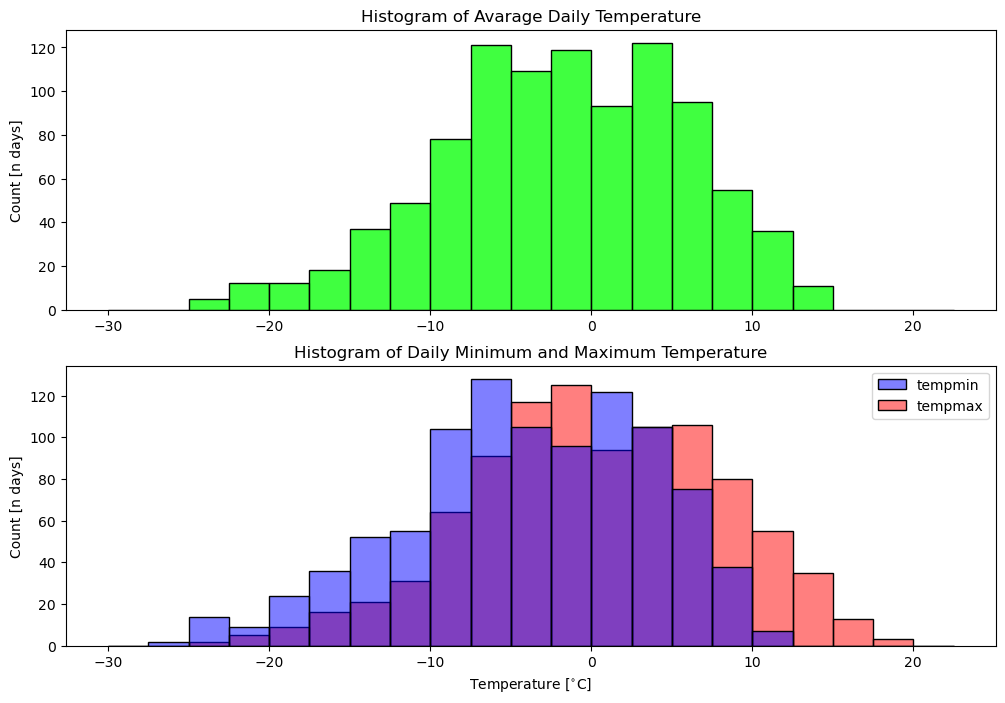

In [14]:
plot_temp_histograms(mussala_weather_data)

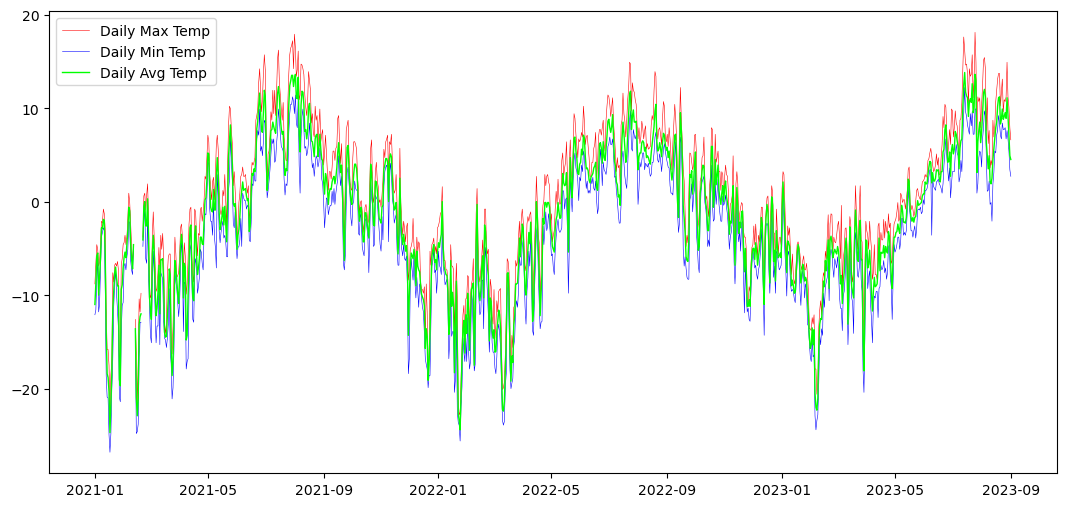

In [15]:
plot_temperatures(mussala_weather_data)

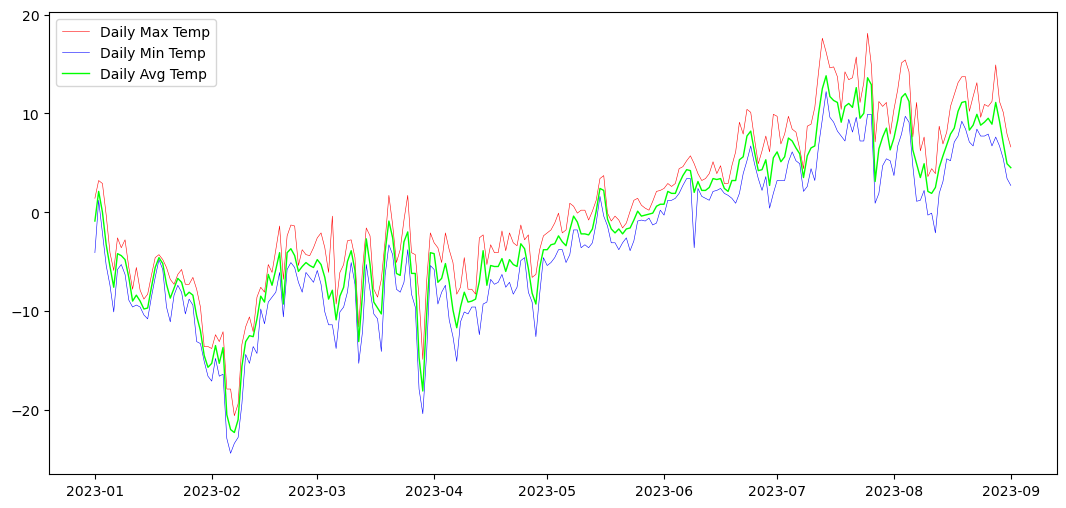

In [16]:
plot_temperatures(mussala_weather_data[mussala_weather_data.datetime.dt.year==2023])

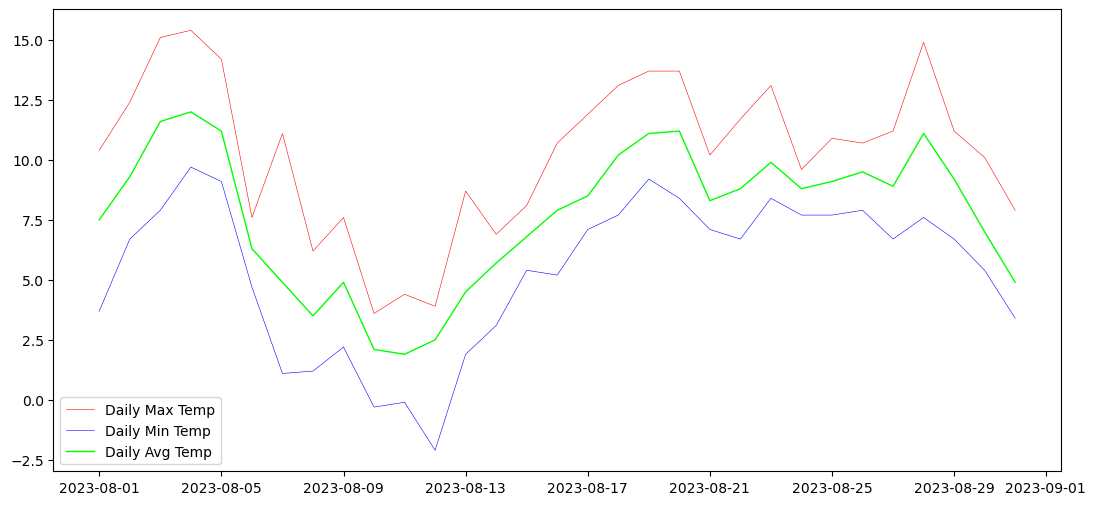

In [17]:
plot_temperatures(mussala_weather_data[(mussala_weather_data.datetime.dt.year==2023) & (mussala_weather_data.datetime.dt.month == 8)])

We plot the avarege daily temperature by year, looking for patterns:

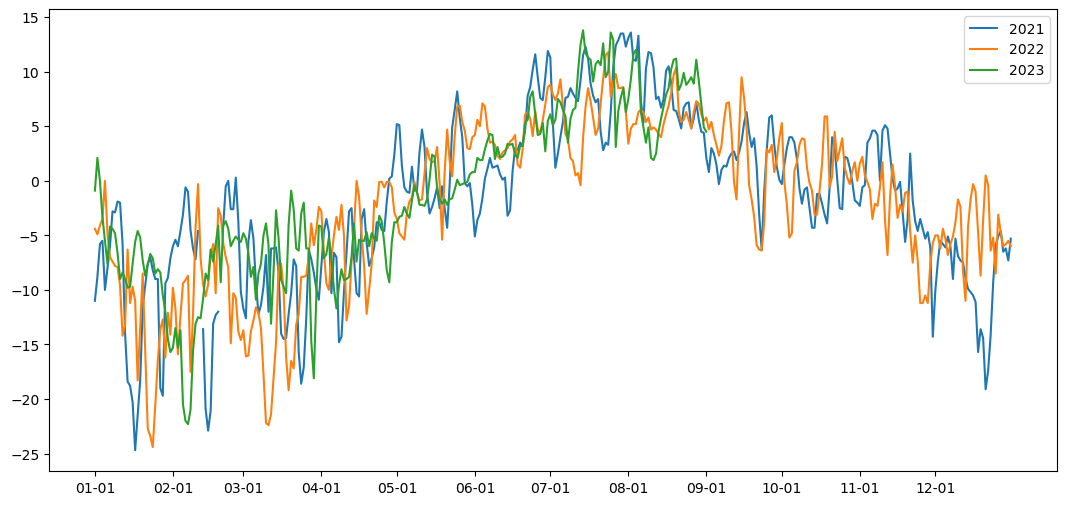

In [18]:
plot_temp_by_year(mussala_weather_data)

In [19]:
# plt.figure(figsize=(13, 6))

# for year in range(2020, 2024):
#     plt.plot(mussala_weather_data.datetime.dt.strftime("%m-%d")[mussala_weather_data.datetime.dt.year==year], mussala_weather_data.temp[mussala_weather_data.datetime.dt.year==year], label = year)

# plt.xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
# plt.legend()
# plt.show()

```Dew```

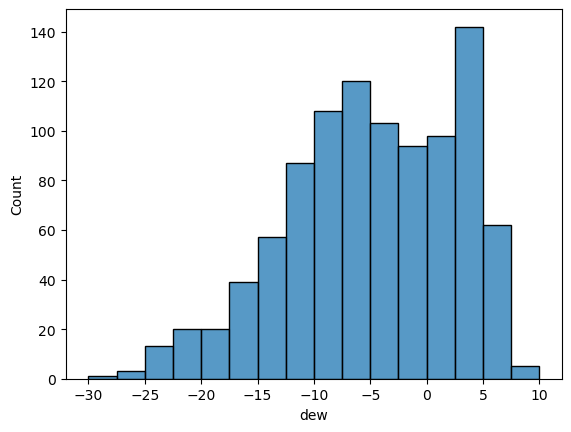

In [20]:
sns.histplot(mussala_weather_data.dew, binwidth = 2.5, binrange = [-30, 10])
plt.show()

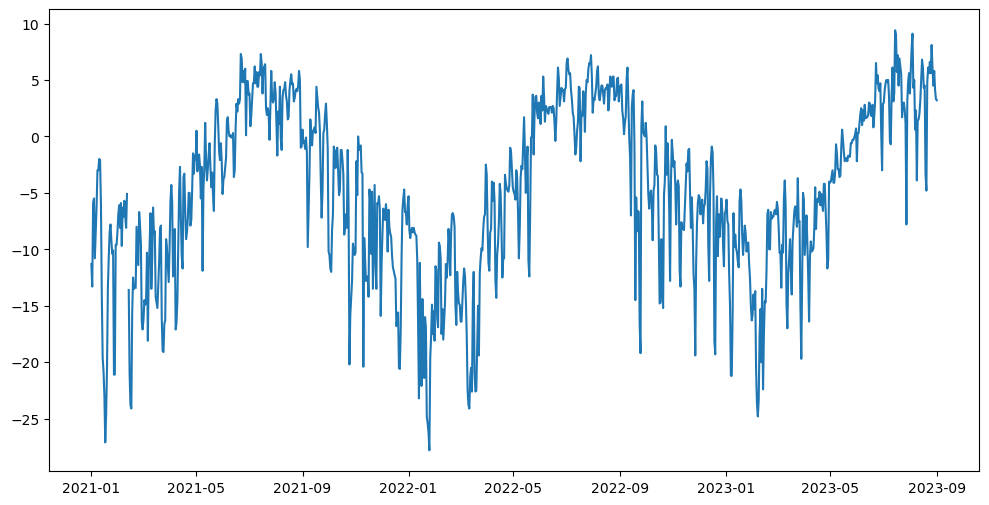

In [21]:
plot_time_series(mussala_weather_data, "dew")

```Humidity```

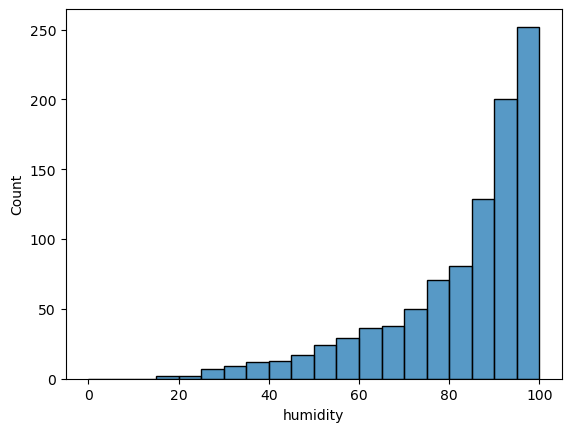

In [22]:
sns.histplot(mussala_weather_data.humidity, binwidth = 5, binrange = [0, 100])
plt.show()

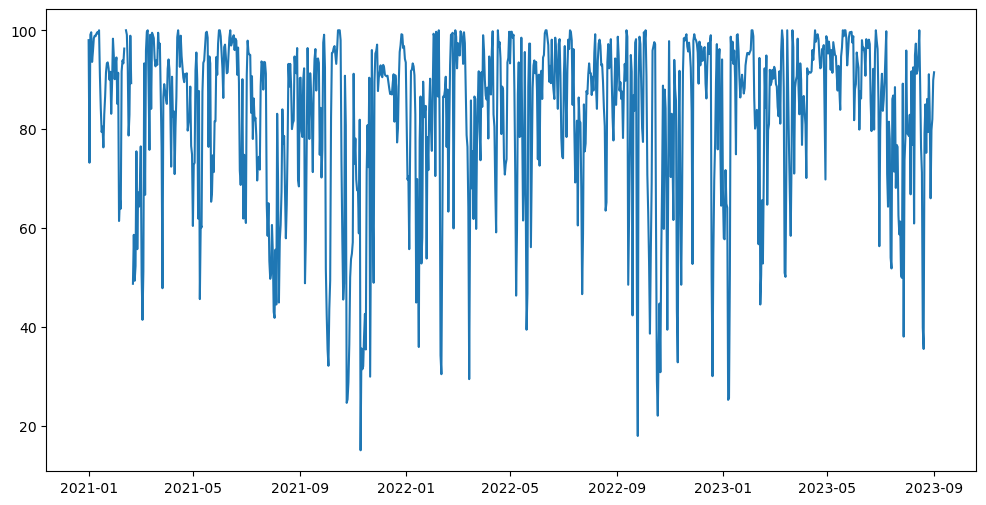

In [23]:
plot_time_series(mussala_weather_data, "humidity")

```precip```

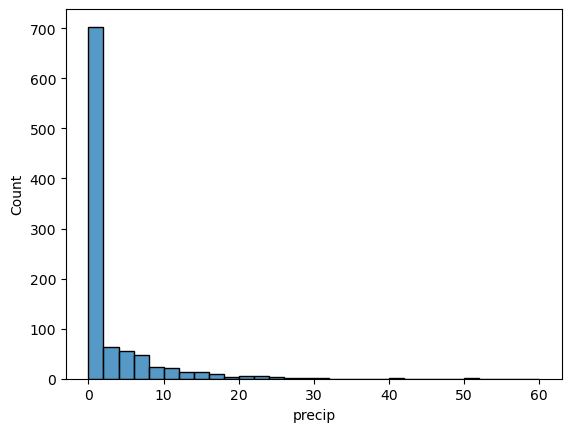

In [24]:
sns.histplot(mussala_weather_data.precip, binwidth = 2, binrange = [0, 60])
plt.show()

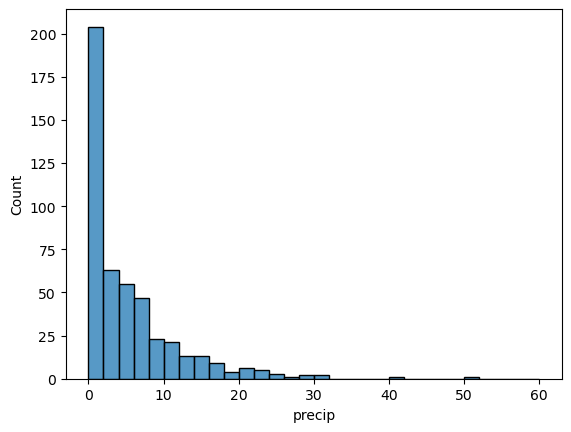

In [25]:
sns.histplot(mussala_weather_data.precip[mussala_weather_data.precip > 0], binwidth = 2, binrange = [0, 60])
plt.show()

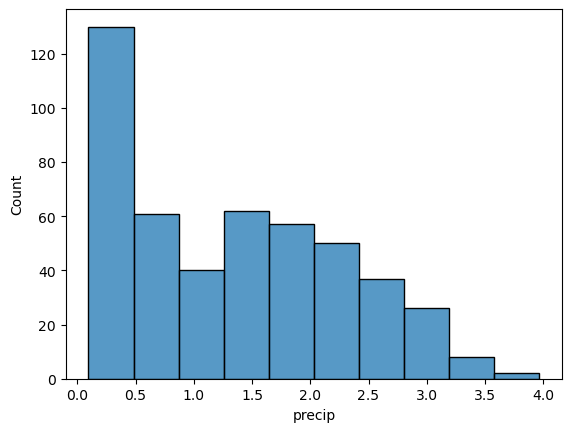

In [26]:
sns.histplot(np.log1p(mussala_weather_data.precip[mussala_weather_data.precip > 0]))
plt.show()

```preciptype```

In [27]:
mussala_weather_data.preciptype.value_counts(dropna = False)

preciptype
NaN          501
snow         260
rain         121
rain,snow     92
Name: count, dtype: int64

In [28]:
mussala_weather_data[(mussala_weather_data.precip == 0) & (mussala_weather_data.preciptype.isna())].shape

(499, 15)

In [29]:
mussala_weather_data.preciptype.str.get_dummies(sep=",")

,rain,snow
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
969,0,0
970,0,0
971,0,0
972,0,0


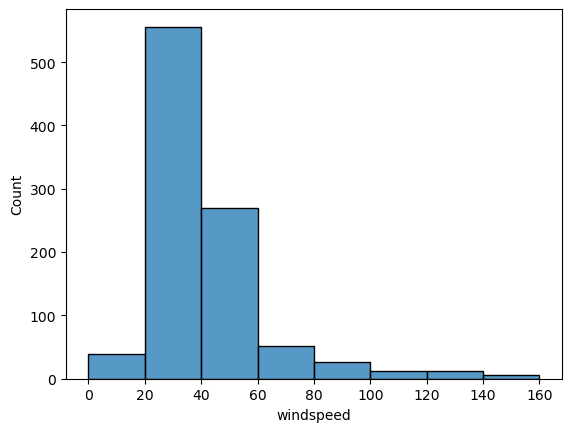

In [30]:
sns.histplot(mussala_weather_data.windspeed, binwidth = 20, binrange = [0, 150])
plt.show()

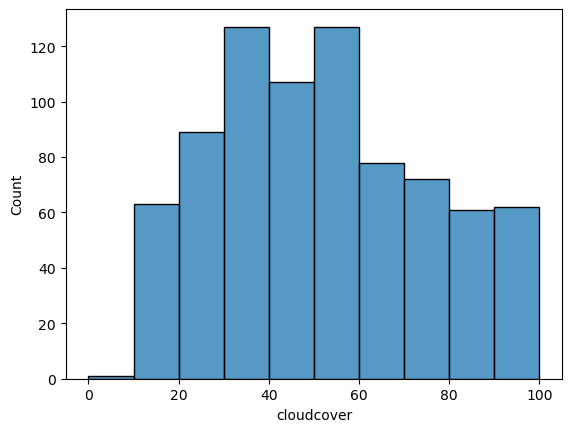

In [31]:
sns.histplot(mussala_weather_data.cloudcover, binwidth=10, binrange=[0,100])
plt.show()

In [32]:
mussala_weather_data.cloudcover[mussala_weather_data.cloudcover < 10]

62    7.5
Name: cloudcover, dtype: float64

In [33]:
mussala_weather_data.conditions.value_counts(dropna = False)

conditions
Partially cloudy                403
Snow, Partially cloudy          128
Snow                            119
Rain, Partially cloudy          110
Clear                            91
Snow, Rain, Partially cloudy     47
Snow, Rain                       30
Rain                              9
Snow, Overcast                    8
Snow, Rain, Overcast              8
Snow, Rain, Fog                   7
Snow, Fog                         5
Overcast                          5
NaN                               2
Rain, Fog                         2
Name: count, dtype: int64

In [34]:
mussala_weather_data.conditions.str.get_dummies(sep=",")

,Fog,Overcast,Partially cloudy,Rain,Clear,Overcast,Partially cloudy,Rain,Snow
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
969,0,0,0,0,0,0,1,0,0
970,0,0,0,0,0,0,1,0,0
971,0,0,0,0,0,0,1,0,0
972,0,0,0,0,0,0,1,0,0


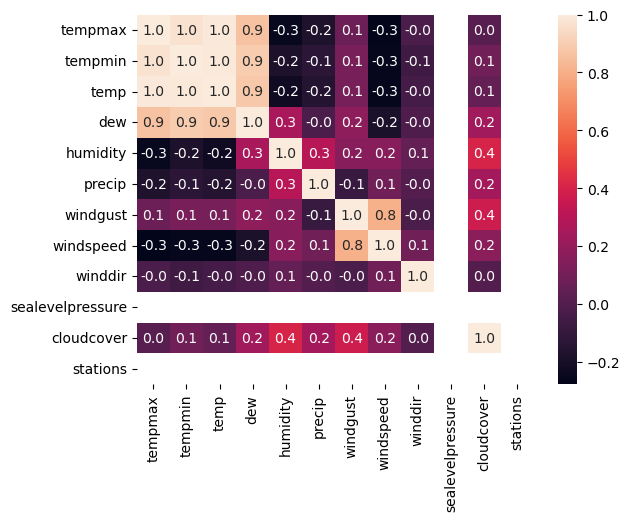

In [35]:
sns.heatmap(mussala_weather_data.corr(numeric_only = True), annot=True, fmt=".1f")
plt.show()

## Sofia

In [36]:
sofia_weather_data = pd.read_csv("data/Sofia 2021-01-01 to 2023-09-26.csv")

In [37]:
sofia_weather_data.head(2)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Sofia,2021-01-01,11.1,-0.9,3.9,11.1,-1.4,3.1,0.1,78.2,...,NaN,NaN,NaN,2021-01-01T07:57:10,2021-01-01T17:03:43,0.58,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,15614099999
1,Sofia,2021-01-02,9.1,-3.9,1.6,7.9,-5.1,0.7,-2.0,78.8,...,NaN,NaN,NaN,2021-01-02T07:57:14,2021-01-02T17:04:36,0.62,Clear,Clear conditions throughout the day.,clear-day,15614099999


In [38]:
sofia_weather_data.shape

(999, 33)

In [39]:
sofia_weather_data.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [40]:
columns_to_keep = [
    "datetime", 
    "tempmax", 
    "tempmin", 
    "temp",
    "dew", 
    "humidity", 
    "precip",
    "precipcover", 
    "preciptype", 
    "snow", 
    "snowdepth", 
    "windgust", 
    "windspeed", 
    "winddir", 
    "sealevelpressure", 
    "cloudcover", 
    "visibility",
    "conditions", 
    "description"
]

In [41]:
sofia_weather_data = sofia_weather_data[columns_to_keep]

In [42]:
sofia_weather_data.dtypes

datetime             object
tempmax             float64
tempmin             float64
temp                float64
dew                 float64
humidity            float64
precip              float64
precipcover         float64
preciptype           object
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
conditions           object
description          object
dtype: object

In [43]:
sofia_weather_data.datetime = pd.to_datetime(sofia_weather_data.datetime)

In [44]:
sofia_weather_data.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,999,2022-05-15 00:00:00,2021-01-01 00:00:00,2021-09-07 12:00:00,2022-05-15 00:00:00,2023-01-19 12:00:00,2023-09-26 00:00:00,NaN
tempmax,999.0,17.732332,-5.9,10.1,18.1,26.1,39.1,9.7905
tempmin,999.0,6.108308,-17.9,0.1,6.1,13.1,21.1,7.597816
temp,999.0,11.786987,-10.0,4.9,11.5,19.1,28.7,8.408543
dew,999.0,5.824725,-12.9,0.5,5.6,12.2,18.4,6.934538
humidity,999.0,70.652452,31.7,61.4,70.9,80.5,96.7,12.224678
precip,997.0,1.720461,0.0,0.0,0.0,0.6,62.0,4.881997
precipcover,999.0,2.244344,0.0,0.0,0.0,4.17,16.67,3.515
snow,999.0,0.156957,0.0,0.0,0.0,0.0,14.4,1.103605
snowdepth,999.0,0.446046,0.0,0.0,0.0,0.0,17.8,1.853524


In [45]:
sofia_weather_data.isna().sum()

datetime              0
tempmax               0
tempmin               0
temp                  0
dew                   0
humidity              0
precip                2
precipcover           0
preciptype          641
snow                  0
snowdepth             0
windgust            972
windspeed             0
winddir               0
sealevelpressure      2
cloudcover            1
visibility            0
conditions            0
description           0
dtype: int64

In [46]:
sofia_weather_data[sofia_weather_data.precip.isna()]

,datetime,tempmax,tempmin,temp,dew,humidity,precip,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,conditions,description
42,2021-02-12,-3.0,-7.0,-5.3,-11.4,62.6,NaN,0.0,NaN,0.0,0.0,68.4,40.7,289.0,NaN,68.0,7.6,Partially cloudy,Partly cloudy throughout the day.
50,2021-02-20,4.0,0.0,1.7,0.1,89.4,NaN,0.0,NaN,0.0,0.0,NaN,14.8,106.2,NaN,100.0,5.1,Overcast,Cloudy skies throughout the day.


In [ ]:
sofia_weather_data.precip = sofia_weather_data.precip.fillna()

In [47]:
sofia_weather_data[sofia_weather_data.cloudcover.isna()]

,datetime,tempmax,tempmin,temp,dew,humidity,precip,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,conditions,description
219,2021-08-08,34.1,13.1,23.8,10.7,48.5,0.0,0.0,NaN,0.0,0.0,NaN,13.0,125.3,1016.1,NaN,15.0,Clear,Partly cloudy throughout the day.


#### Numerical features

Temperature features - ```temp```, ```tempmax``` and ```tempmin```:

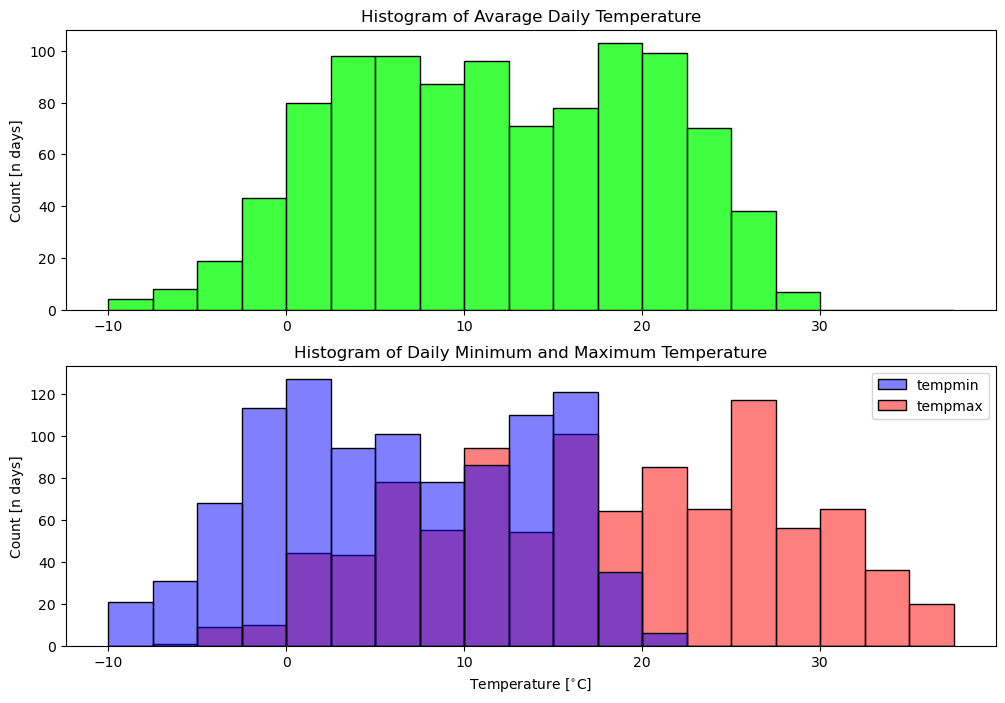

In [48]:
plot_temp_histograms(sofia_weather_data, binrange = [-10, 36])

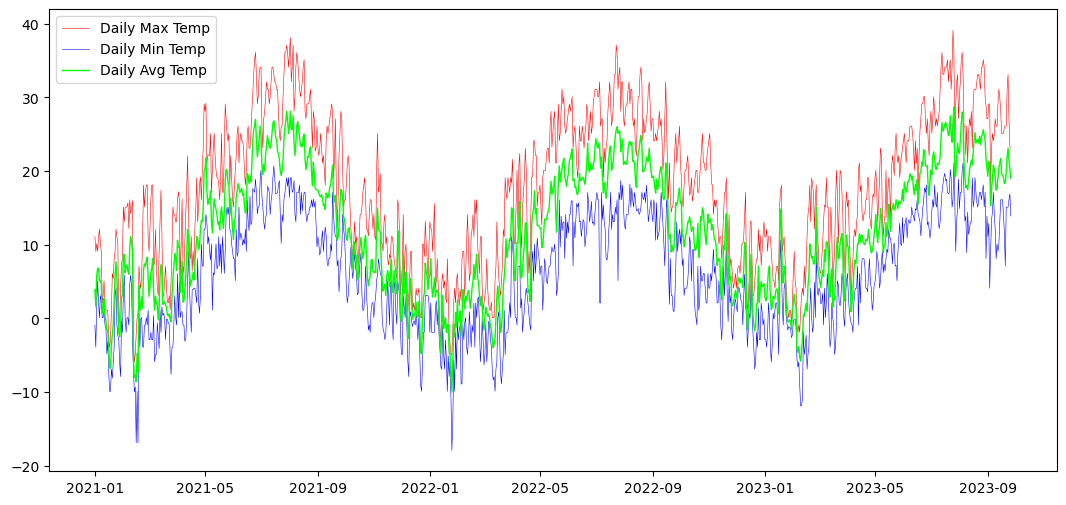

In [49]:
plot_temperatures(sofia_weather_data)

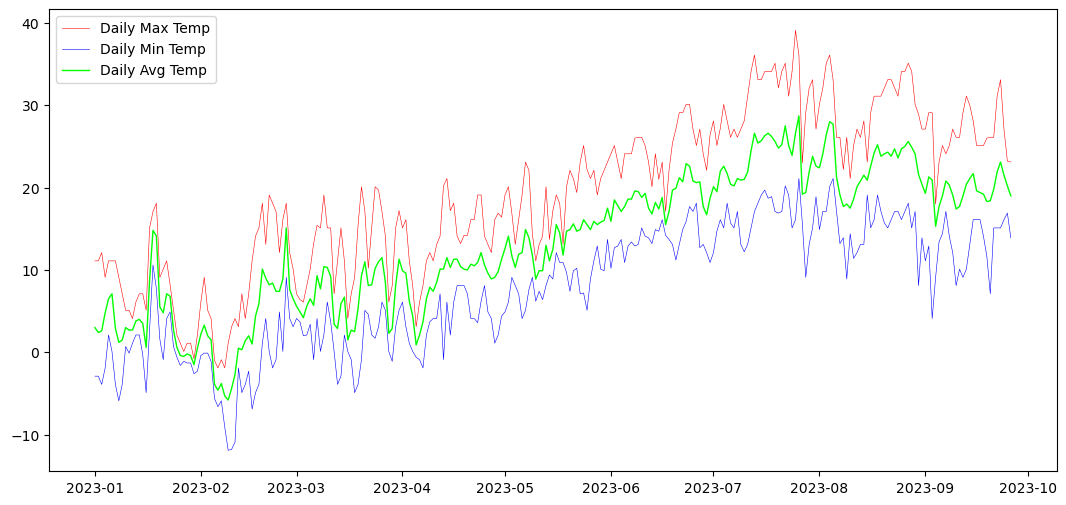

In [50]:
plot_temperatures(sofia_weather_data[sofia_weather_data.datetime.dt.year==2023])

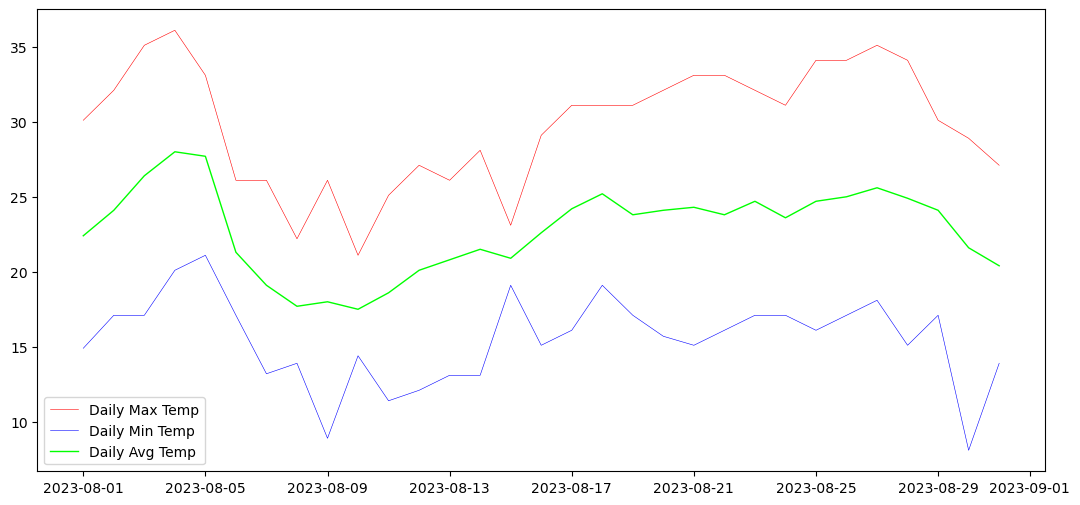

In [51]:
plot_temperatures(sofia_weather_data[(sofia_weather_data.datetime.dt.year==2023) & (sofia_weather_data.datetime.dt.month == 8)])

We plot the avarege daily temperature by year, looking for patterns:

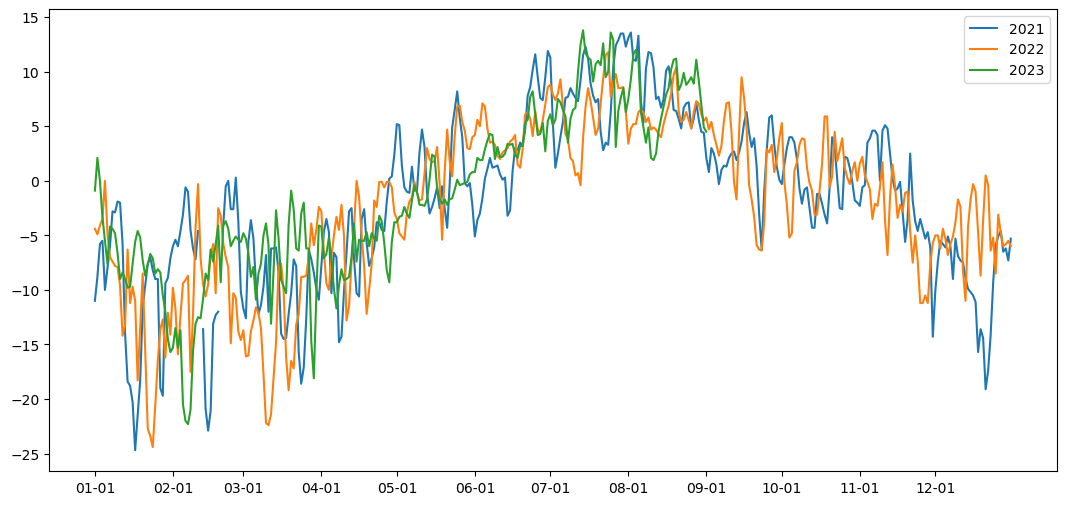

In [52]:
plot_temp_by_year(sofia_weather_data)

```Dew```

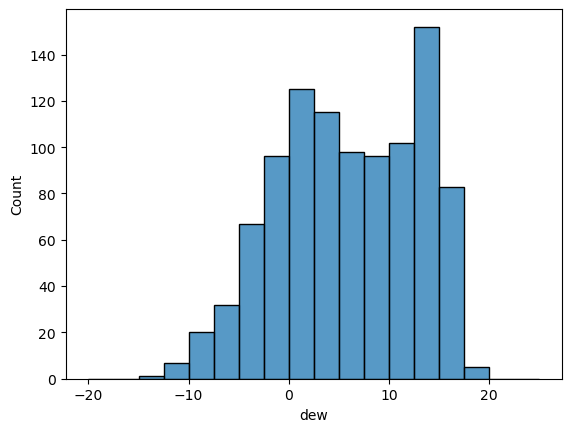

In [53]:
sns.histplot(sofia_weather_data.dew, binwidth = 2.5, binrange = [-20, 25])
plt.show()

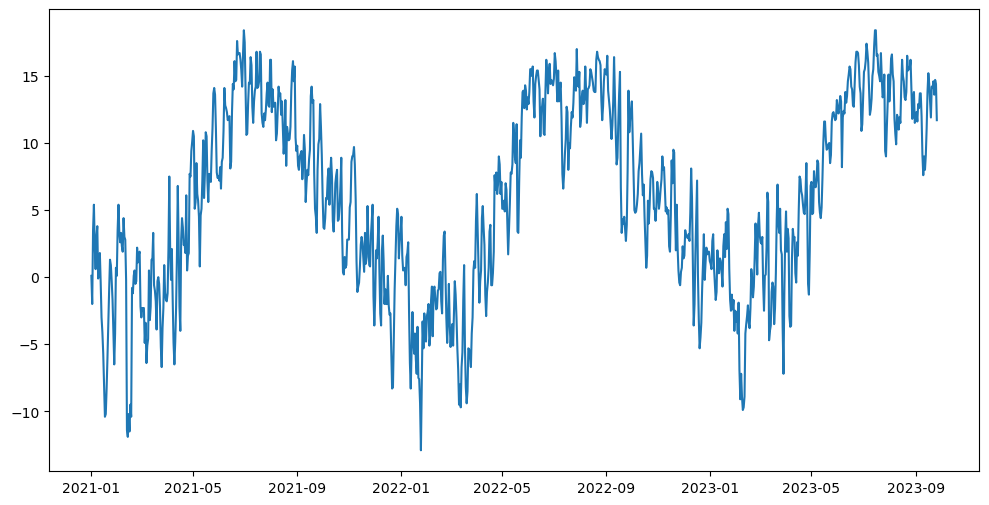

In [54]:
plot_time_series(sofia_weather_data, "dew")

```Humidity```

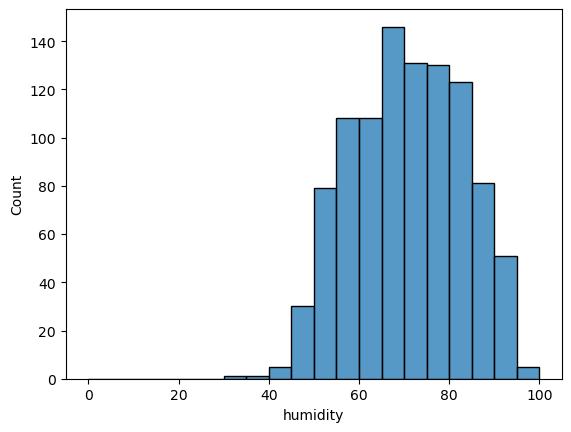

In [55]:
sns.histplot(sofia_weather_data.humidity, binwidth = 5, binrange = [0, 100])
plt.show()

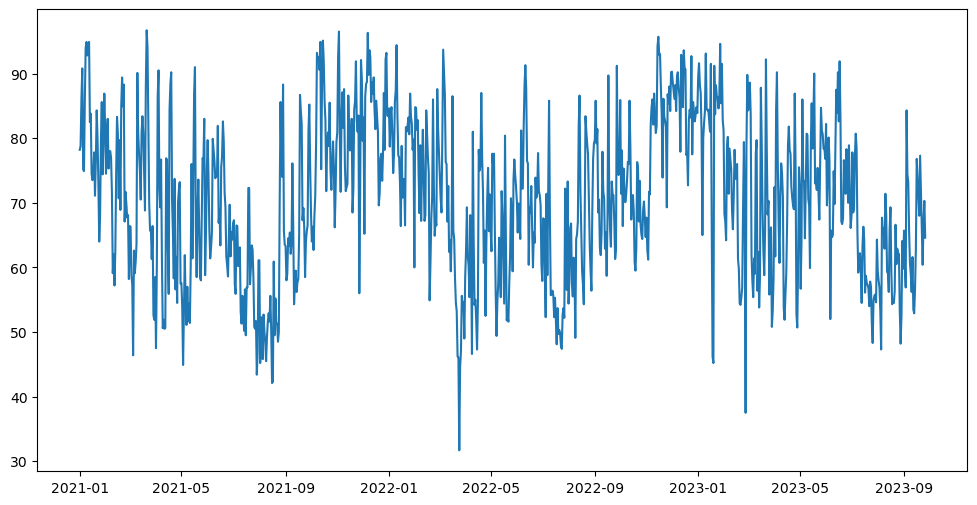

In [56]:
plot_time_series(sofia_weather_data, "humidity")

```precip```

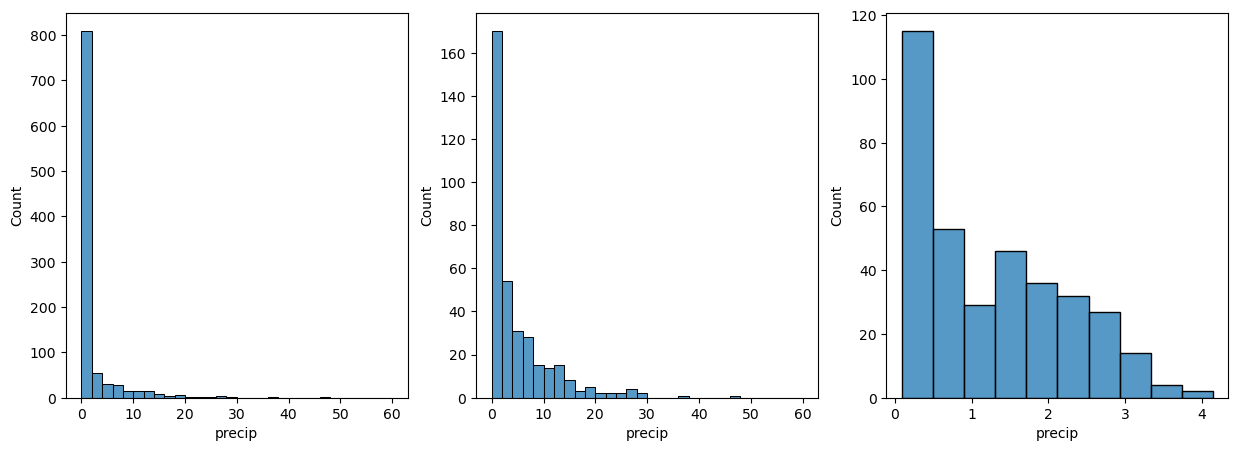

In [57]:
plot_histograms_log_transform(sofia_weather_data, "precip")

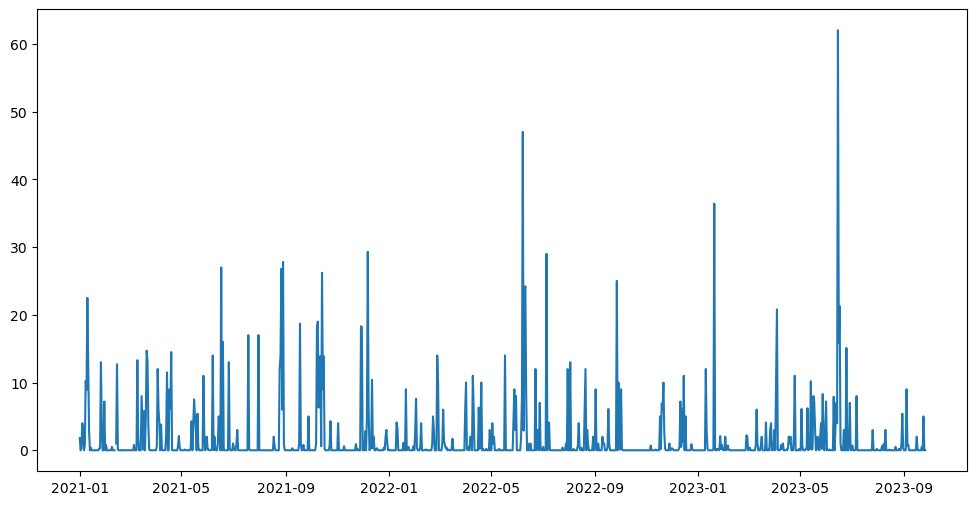

In [90]:
plot_time_series(sofia_weather_data, "precip")

In [58]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# sns.histplot(sofia_weather_data.precip, ax = ax1, binwidth = 2, binrange = [0, 60])
# sns.histplot(sofia_weather_data.precip[sofia_weather_data.precip > 0], ax = ax2, binwidth = 2, binrange = [0, 60])
# sns.histplot(np.log1p(sofia_weather_data.precip[sofia_weather_data.precip > 0]), ax = ax3)

# plt.show()

```preciptype```

In [59]:
sofia_weather_data.preciptype.value_counts(dropna = False)

preciptype
NaN          641
rain         281
rain,snow     67
snow          10
Name: count, dtype: int64

In [60]:
sofia_weather_data[(sofia_weather_data.precip == 0) & (sofia_weather_data.preciptype.isna())].shape

(639, 19)

In [61]:
sofia_weather_data.preciptype.str.get_dummies(sep=",")

,rain,snow
0,1,1
1,0,0
2,1,0
3,1,0
4,1,0
...,...,...
994,1,0
995,0,0
996,1,0
997,0,0


`snow`

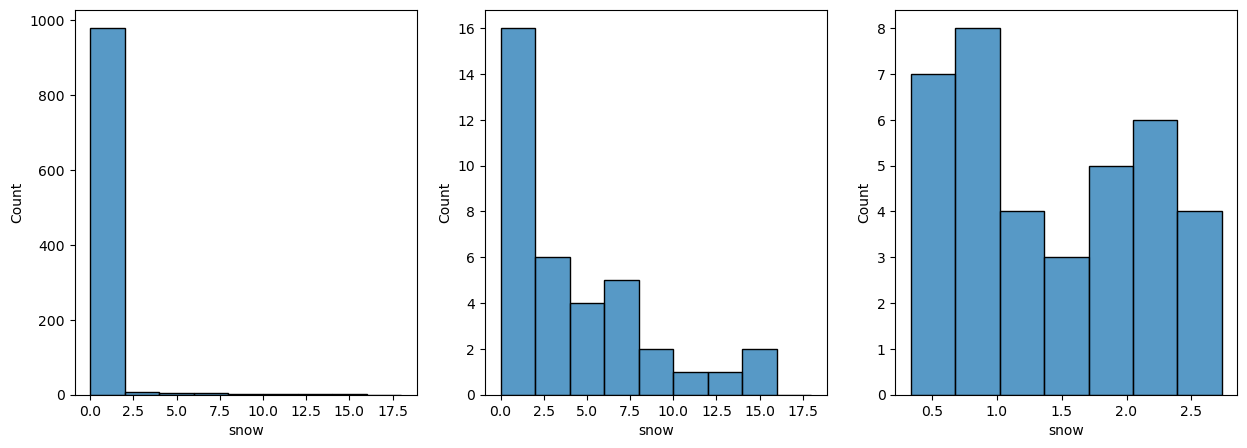

In [62]:
plot_histograms_log_transform(sofia_weather_data, "snow", binrange= [0, 18])

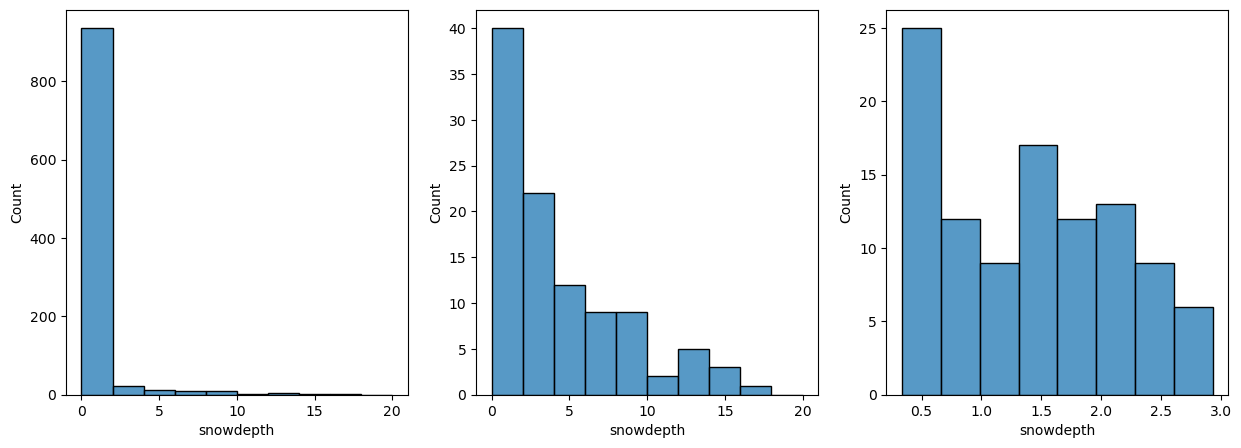

In [63]:
plot_histograms_log_transform(sofia_weather_data, "snowdepth", binrange= [0, 20])

In [64]:
sofia_weather_data.columns

Index(['datetime', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'precip',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'conditions', 'description'],
      dtype='object')

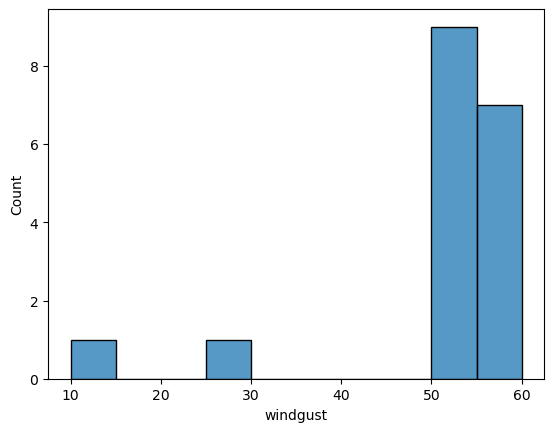

In [65]:
sns.histplot(sofia_weather_data.windgust, binwidth = 5, binrange = [10, 60])
plt.show()

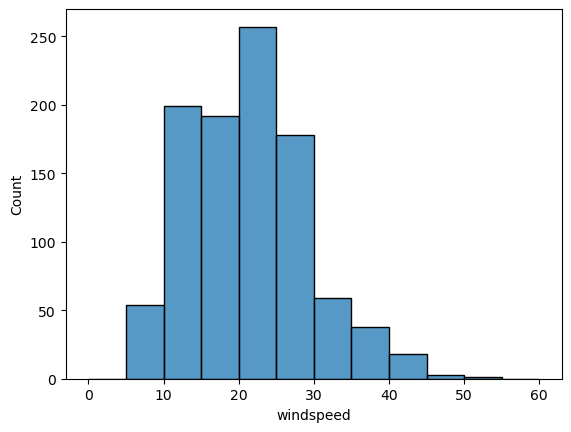

In [66]:
sns.histplot(sofia_weather_data.windspeed, binwidth = 5, binrange = [0, 60])
plt.show()

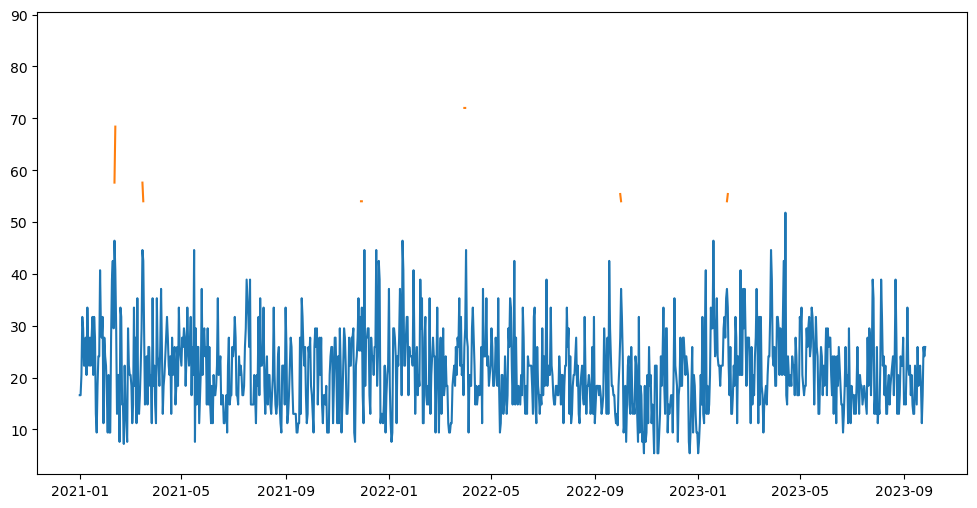

In [67]:
plot_time_series(sofia_weather_data, ["windspeed", "windgust"])

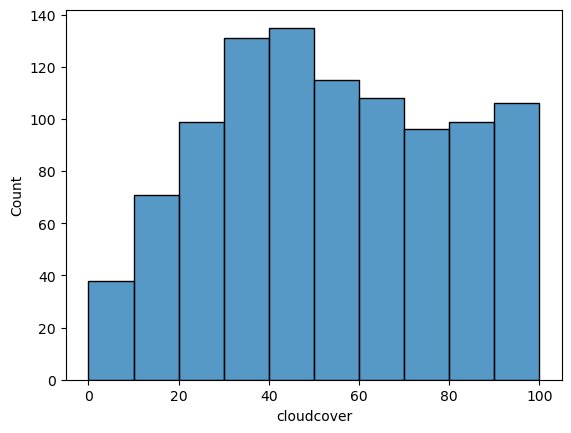

In [68]:
sns.histplot(sofia_weather_data.cloudcover, binwidth=10, binrange=[0,100])
plt.show()

In [69]:
sofia_weather_data.cloudcover[sofia_weather_data.cloudcover < 5]

56     0.0
57     2.2
85     4.3
276    4.0
447    0.0
450    1.4
467    2.5
468    0.0
559    1.4
566    4.0
567    1.4
669    0.0
770    3.0
771    2.7
Name: cloudcover, dtype: float64

In [70]:
sofia_weather_data.cloudcover.isna().sum()

1

In [71]:
sofia_weather_data.conditions[sofia_weather_data.cloudcover.isna()]

219    Clear
Name: conditions, dtype: object

In [72]:
sofia_weather_data.cloudcover = sofia_weather_data.cloudcover.fillna(0.0)

In [73]:
sofia_weather_data.conditions.value_counts(dropna = False)

conditions
Partially cloudy                506
Rain, Partially cloudy          236
Clear                           115
Rain, Overcast                   43
Snow, Rain, Overcast             39
Snow, Rain, Partially cloudy     28
Overcast                         20
Snow, Partially cloudy            7
Snow, Overcast                    3
Rain                              2
Name: count, dtype: int64

In [74]:
mussala_weather_data.conditions.str.get_dummies(sep=",")

,Fog,Overcast,Partially cloudy,Rain,Clear,Overcast,Partially cloudy,Rain,Snow
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
969,0,0,0,0,0,0,1,0,0
970,0,0,0,0,0,0,1,0,0
971,0,0,0,0,0,0,1,0,0
972,0,0,0,0,0,0,1,0,0


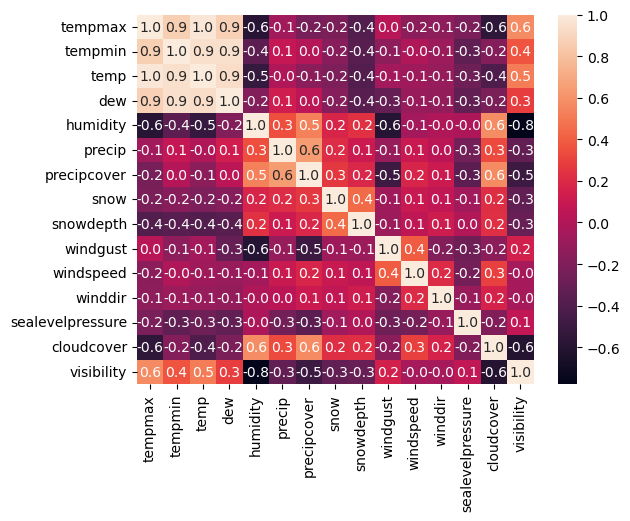

In [75]:
sns.heatmap(sofia_weather_data.corr(numeric_only = True), annot=True, fmt=".1f")
plt.show()

In [76]:
acf(sofia_weather_data.temp)

array([1.        , 0.96455466, 0.92346839, 0.89399754, 0.87437496,
       0.86171057, 0.85307001, 0.84744816, 0.84023534, 0.83226234,
       0.82376197, 0.81598765, 0.81278821, 0.81117029, 0.80678271,
       0.79984089, 0.79325587, 0.78473679, 0.77373283, 0.7650513 ,
       0.75888348, 0.75428286, 0.75095523, 0.74520119, 0.73810511,
       0.73157994, 0.72340231, 0.7197608 , 0.71875982, 0.71574726])

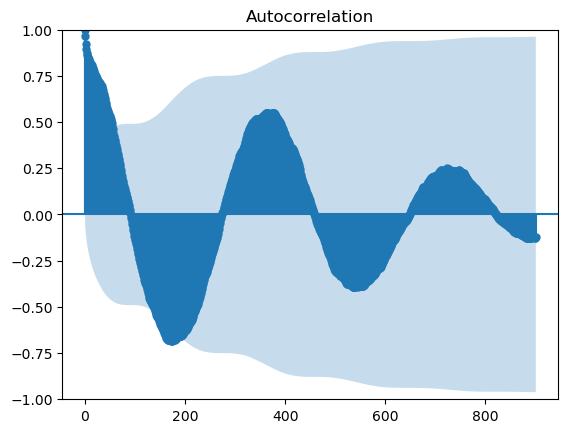

In [77]:
plot_acf(sofia_weather_data.temp, lags = 900)
plt.show()

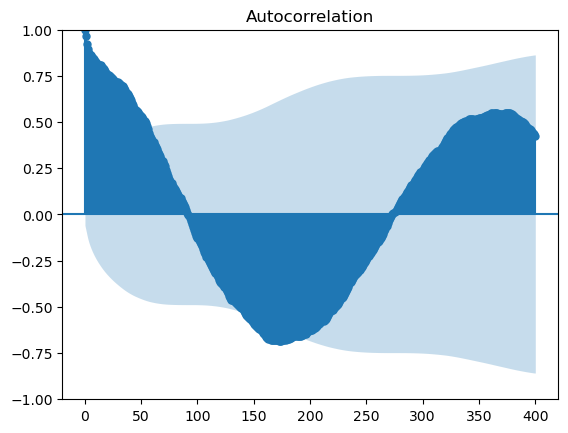

In [78]:
plot_acf(sofia_weather_data.temp, lags = 400)
plt.show()

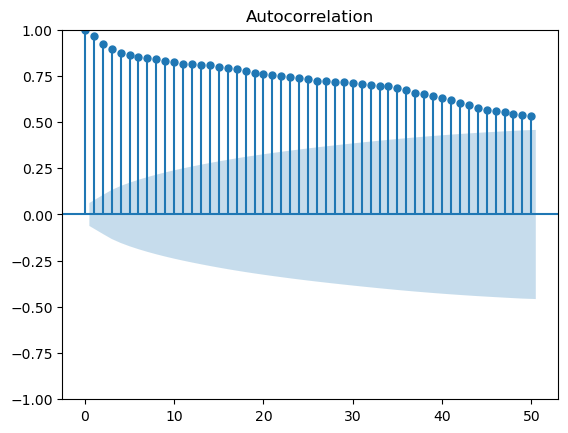

In [79]:
plot_acf(sofia_weather_data.temp, lags = 50)
plt.show()

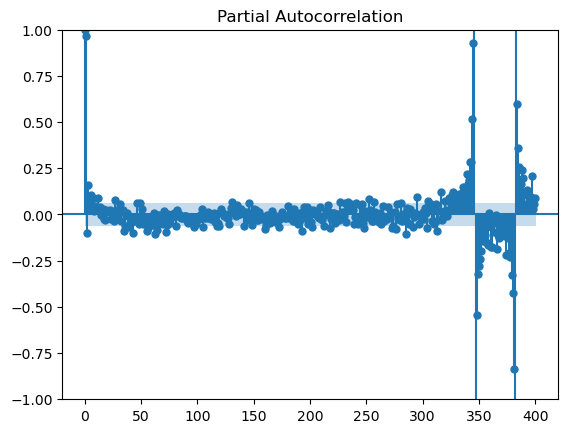

In [86]:
plot_pacf(sofia_weather_data.temp, lags = 400)
plt.show()

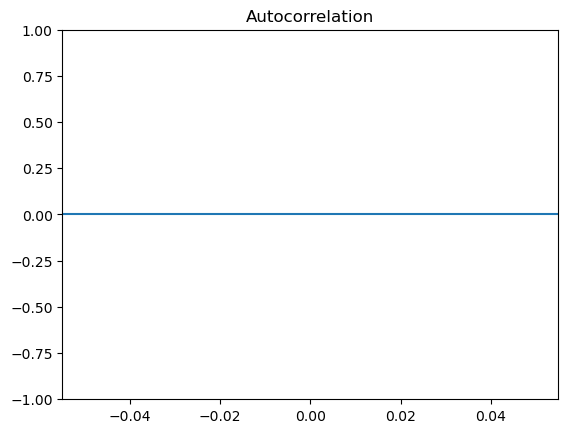

In [88]:
plot_acf(sofia_weather_data.precip, lags = 500)
plt.show()